# Step 1. EDA

In [1]:
#Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

c:\Users\kurom\anaconda3\envs\dl-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
financial_news = pd.read_csv('all-data.csv', encoding='latin', header=None) #read csv set header to none because columns have no title
financial_news.rename(columns={0: 'label', 1:'news'}, inplace=True) #rename columns

In [3]:
#Check DF head and Tail
financial_news.head()
financial_news.tail()

,label,news
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
4845,negative,Sales in Finland decreased by 10.5 % in Januar...


In [4]:
#Check shape of train df
financial_news.shape

(4846, 2)

In [5]:
#Check information of df
#we can see there is no missing values 
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   news    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


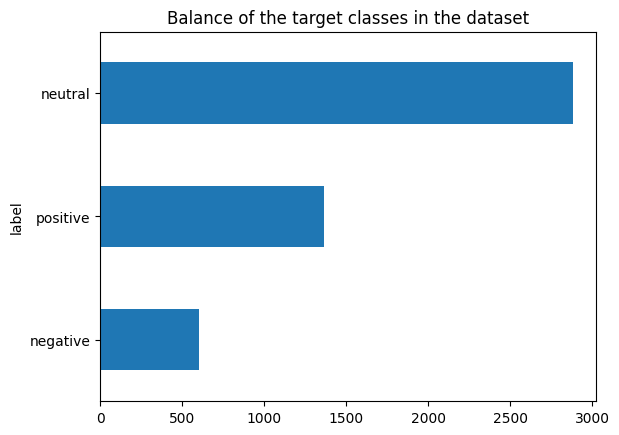

label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [6]:
#Check balance of the data set
financial_news['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is imbalanced
print(financial_news['label'].value_counts())

In [7]:
#Check the maximum lenght of the documents
financial_news['len'] = financial_news['news'].apply(lambda text: len(text.split()))
financial_news['len'].max()

81

In [8]:
financial_news.drop(columns={'len'}, inplace=True)
financial_news.head(3)

,label,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...


# Step 2. Pre-processing

### Approach 1. do not balance classes

In [9]:
#First let's map the labels to integers

lable_map = {'negative': -1, 'neutral': 0, 'positive': 1}
financial_news['label'] = financial_news['label'].map(lable_map)
financial_news.head()

,label,news
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,-1,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...


In [10]:
#Save approach 1 dataframe to folder
financial_news.to_csv('data/financial_news_1.csv', index=False)

### Approach 2. Downsampling

In [11]:
# Let's downsample positive and neutral labels to create a balanced data set
financial_news_ds = financial_news.copy() # Copy DF

#Now let's separate our 3 classes to perform downsample
financial_news_n = financial_news_ds.loc[financial_news_ds.label == -1] #Negative label
financial_news_0 = financial_news_ds.loc[financial_news_ds.label ==  0] #Neutral label
financial_news_1 = financial_news_ds.loc[financial_news_ds.label ==  1] #Positive label 

In [12]:
#Check separated labels
financial_news_n['label'].unique()
financial_news_0['label'].unique()
financial_news_1['label'].unique()

array([1], dtype=int64)

In [13]:
#Downsample positive and neutral labels to be same length as negative label
financial_news_0 = financial_news_0.iloc[0:604, :]
financial_news_1 = financial_news_1.iloc[0:604, :]

In [14]:
#Check shapes
financial_news_0['label'].shape
financial_news_1['label'].shape

(604,)

In [15]:
#put everything together again
financial_news_ds = pd.concat([financial_news_n, financial_news_0, financial_news_1])

#shuffle rows and reset index
financial_news_ds = financial_news_ds.sample(frac=1).reset_index(drop=True)

#check df
financial_news_ds.tail()

,label,news
1807,-1,"As a result , the company will temporarily lay..."
1808,0,"In Switzerland , Teleste have been an establis..."
1809,-1,"In July-September 2009 , Konecranes ' sales de..."
1810,0,"The inventors are Bylander Johan , Ponten Fred..."
1811,0,"The contract , which was signed yesterday , wi..."


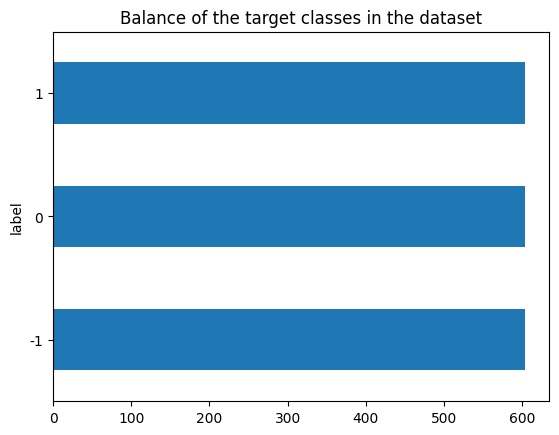

label
-1    604
 0    604
 1    604
Name: count, dtype: int64


In [16]:
#Check balance of the data set
financial_news_ds['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is imbalanced
print(financial_news_ds['label'].value_counts())

In [21]:
#save approach 2 dataframe 
financial_news_ds.to_csv('data/financial_news_2.csv', index=False)

# Step 3. Feature extraction

In [43]:
# Load raw data set
from datasets import load_dataset
from datasets import DatasetDict
raw_dataset_1 = load_dataset('csv', data_files='data/financial_news_1.csv')
raw_dataset_2 = load_dataset('csv', data_files='data/financial_news_2.csv')

In [44]:
#Check raw data sets
raw_dataset_1
raw_dataset_2

DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 1812
    })
})

In [45]:
#Create train, test and validation splits

#First split into train/test 30% for split, and specify seed
train_test_split_1 = raw_dataset_1['train'].train_test_split(test_size=0.3, seed=18)
train_test_split_2 = raw_dataset_2['train'].train_test_split(test_size=0.3, seed=18)

#Now split into train/test/val making 40% of test data for validation and specify seed
train_test_val_split_1 = train_test_split_1['test'].train_test_split(test_size=0.4, seed=18)
train_test_val_split_2 = train_test_split_2['test'].train_test_split(test_size=0.4, seed=18)

#Gather everything into single dataset dicts
train_test_val_split_1 = DatasetDict({'train': train_test_split_1['train'], 'test': train_test_val_split_1['train'], 'valid': train_test_val_split_1['test']})
train_test_val_split_2 = DatasetDict({'train': train_test_split_2['train'], 'test': train_test_val_split_2['train'], 'valid': train_test_val_split_2['test']})

train_test_val_split_1

DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 3392
    })
    test: Dataset({
        features: ['label', 'news'],
        num_rows: 872
    })
    valid: Dataset({
        features: ['label', 'news'],
        num_rows: 582
    })
})